<a href="https://colab.research.google.com/github/EmrahYener/DLMAINLPCV01_demo/blob/master/machine_translation_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Translation**

Machine translation (MT) is the task of automatically translating text or speech from one natural language to another. MT is a subfield of NLP that leverages the disciplines of artificial intelligence, information theory, computer science, and statistics.

To build an MT system, we can find different frameworks with statistical machine translation (SMT) and neural machine translation (NMT).

SMT replaces classic rule-based MT systems with models that learn translation through examples. Translations in SMT are generated on the basis of statistical models whose parameters are derived from the analysis of bilingual text corpora.

NMT uses an artificial neural network to learn a statistical
model for MT. Unlike a phrase-based SMT system, an NMT system consists of a single, large neural network that reads a sentence and outputs a translation. Normally an NMT system is built on bidirectional recurrent neural networks (RNNs) using an encoder-attention-decoder architecture  [[1]](#scrollTo=hC1nskpFvqjO).

Since NMT is becoming increasingly popular, there are already many toolkits available. This notebook shows an example of NMT with an encoder-attention-decoder architecture, i.e. a sequence-to-sequence network with an attention mechanism.

Some of the explanations, codes and pictures used in this notebook are taken from [[2]](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).




## **NMT with sequence-to-sequence network**
An RNN is a network that operates on a sequence and uses its own output as input for subsequent steps.

A sequence-to-sequence network (also denoted as seq2seq network or encoder-decoder network) is a model consisting of two RNNs which are denoted as encoder and decoder. The encoder reads an input sequence and outputs a single vector. The decoder reads that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

Consider the sentence “Je ne suis pas le chat noir” → “I am not the black cat”. Most of the words in the input sentence have a direct translation in the output sentence, but are in slightly different orders, e.g. “chat noir” and “black cat”. Because of the “ne-pas” construction in the French language, there is also one more word in the input sentence. It would be difficult to produce a correct translation directly from the sequence of input words.

![seq2seq](https://raw.githubusercontent.com/iubh/DLMAINLPCV01/master/data/nlp/seq2seq.png)


In this example, we will also use an attention mechanism to improve the model efficency. With an attention mechanism, the decoder learns to focus over a specific range of the input sequence.

For machine translation with a seq2seq network, we will apply the following steps:

* Upload dataset
* Import libraries
* Create classes and functions
* Perform model training
* Perform model evaluation
* Visualize attention

For more details about the seq2seq architecture, please refer to [[3]](https://arxiv.org/abs/1409.3215).




### Upload dataset
The dataset of this project ``eng-fra.txt`` contains thousands of tab separated English-to-French translation pairs [[4]](https://www.manythings.org/anki/).

To upload the dataset, we clone the related IU GitHub portfolio [[5]](https://github.com/iubh/DLMAINLPCV01).


This dataset contains two sentences in each line. The first sentence of each line is an English text and the second sentence is the French translation of it. You can see a few example lines below:

* You are free to go.	Vous êtes libres de partir.
* You are impossible.	Vous êtes insupportable.
* You are overworked.	Tu es surmené.
* You are very brave.	Tu es très courageux.

The dataset contains 135,842 sentence pairs.


In [1]:
# Clone the IH GitHub portfolio
!git clone https://github.com/iubh/DLMAINLPCV01.git

Cloning into 'DLMAINLPCV01'...
remote: Enumerating objects: 819, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 819 (delta 142), reused 160 (delta 132), pack-reused 640
Receiving objects: 100% (819/819), 86.65 MiB | 27.04 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Checking out files: 100% (127/127), done.


### Import libraries
We import libraries to prepare the dataset and create a seq2seq network. Also we use the ``matplotlib`` library to visualize the diagrams of the training loss and the attention mechanism.

In [2]:
# Import "open" library to open the dataset "eng-fra.txt"
from io import open

# Import the "unicodedata" library to normalize the dataset "eng-fra.txt"
import unicodedata

# Import "re" library to use regex in the "normalizeString" function
import re

# Import "random" library to choose or print random sentence pairs
import random

# Import "pytorch" libraries for creating seq2seq network
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Define PyTorch device to run CUDA operations. If CUDA is not available, PyTorch uses CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import "matplotlib" libraries to visualize training loss and attention
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Prepare dataset
In this section, we prepare our dataset for the seq2seq network.

We create the following class:
* ``Language``

We create the following functions:
* ``normalizeString``
* ``readLanguages``
* ``filterPairs``


#### Create ``Language`` class
The class ``Language`` contains the following functions:
*  ``__init__``: initializes a language instance.
* ``addWord``: is a helper function that runs inside the ``addWord`` function. It creates mapping between words and corresponding indexes and saves to the dictionaries ``word2index`` and ``index2word``. It also creates mapping between words and their occurences and saves to the dictionary ``word2count``.
* ``addSentence``: runs the ``addWord`` function over each sentence.


In [3]:
# We assign the first two indexes to SOS (start-of-sequence) and EOS (end-of-sequence) tokens
SOS_token = 0
EOS_token = 1

# This class contains 3 functions. 
## "__init__" is used to initialize a language instance
## "addWord" is used to create mapping between words and indexes. It also counts the frequency of each word.
## "addSentence" is used to run "addWord" function over each sentence.
class Language:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.word_index = 2   # The first two index numbers are assigned to SOS and EOS. The variable "word_index" starts from 2.

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.word_index
            self.word2count[word] = 1
            self.index2word[self.word_index] = word
            self.word_index += 1
        else:
            self.word2count[word] += 1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

#### Create ``normalizeString`` function
In this section, we create the function ``normalizeString`` to normalize the dataset. 
It is used to lowercase the string, remove non-letter characters and exclamation marks. Also it executes the helper function ``removeStringAccent``.

The helper function ``removeStringAccent`` is used to remove accents from a given string. In the French alphabet, some letters have accent marks such as â, ê, î, ô, û. The function ``removeStringAccent`` takes a unicode string and returns a string without accents. You can see an example below:
* With accent: 'Découvrez tous les logiciels à télécharger'

* Without accent: 'Decouvrez tous les logiciels a telecharger'

In [4]:
# Define a helper function to remove string accents
def removeStringAccent(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Define the "normalizeString" function
## Execute the "removeStringAccent" function
## Lowercase the characters
## Remove the non-letter characters and exclamation marks
def normalizeString(s):
    s = removeStringAccent(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

#### Create ``readLanguages`` function
At the [Upload dataset](#scrollTo=BjQmYSv_L1rl) step, we have cloned the IU GitHub portfolio. As expained in that section, the dataset ``eng-fra.txt`` contains sentence pairs. The function ``readLanguages`` reads the dataset, prepares sentence pairs and defines the language of the first and second sentences of the pairs. 

This function has 3 inputs:
* ``language1`` and ``language2``: are string variables. They allow us to define the language of the first and second sentences of each pair.
* ``reverse``: is a boolean variable. The sentence pairs are all English to French, so if we want to  change the order of sentence pairs as French to English, we set ``reverse=True``.


This function normalizes sentece pairs with the ``normalizeString`` function and saves them to the list ``pairs``. 

This function also calls the ``Language`` class and initializes two language instances ``input_language`` and ``output_language``.

It returns three outputs ``input_language``, ``output_language``and ``pairs``.


In [22]:
# Create the "readLanguages" function to:
## read the dataset "eng-fra.txt"
## create English-French sentence pairs (or French-English if "reverse=True") 
## initialize language instances "input_language" and "output_language"
def readLanguages(language1, language2, reverse=False):
    print("Reading lines...")

    # Read the dataset and split into lines
    lines = open('/content//DLMAINLPCV01/data/nlp/%s-%s.txt' % (language1, language2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make language instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_language = Language(language2)
        output_language = Language(language1)
    else:
        input_language = Language(language1)
        output_language = Language(language2)


    return input_language, output_language, pairs

#### Create ``filterPairs`` function
We have created functions to read our dataset. However, our dataset contains 135,842 sentence pairs and we can filter out some sentences to reduce the training time.

In this section we create the function ``filterPairs`` to filter some of the sentence pairs. The purpose of this function is to trim the dataset to only relatively short and simple sentences.

To filter the sentence pairs by length and content, we use two variables, the integer ``max_length`` and the list ``eng_prefixes``.

The integer ``max_length`` defines the maximum length of the sentences. In this example, we set ``max_length=10``.

The list ``eng_prefixes`` is used to choose only the sentences which begin with the following words:
* "i am ", "i m ",
* "he is", "he s ",
* "she is", "she s ",
* "you are", "you re ",
* "we are", "we re ",
* "they are", "they re "


In [6]:
# Define the integer ``max_length`` and set to 10
max_length = 10

# Define the list ``eng_prefixes``
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re " )

# Define the helper function "filterPair" to filter sentence pairs according to ``max_length`` and ``eng_prefixes``
## Return the given sentence pair "p" if it meets the conditions
def filterPair(p):
    return len(p[0].split(' ')) < max_length and \
        len(p[1].split(' ')) < max_length and \
        p[1].startswith(eng_prefixes)

# Create the "filterPairs" function
## Run "filterPair" function over all sentence pairs
## Return all filtered sentence pairs
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# execute the "filterPairs" function



#### Execute functions and create dataset
The full process for preparing the data is:

* Read text file and split into lines, split lines into pairs
* Normalize text, filter by length and content
* Make word lists from sentences in pairs

In [42]:
# Create "prepareData" function
def prepareData(language1, language2, reverse=False):
    input_language, output_language, pairs = readLanguages(language1, language2, reverse)
    print("\nRead %s sentence pairs" % len(pairs))

    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
 
    for pair in pairs:
        input_language.addSentence(pair[0])
        output_language.addSentence(pair[1])

    print("\nCounted words:")
    print(input_language.name, input_language.word_index)
    print(output_language.name, output_language.word_index)

    return input_language, output_language, pairs


# Run "prepareData" function and print a random sentence pair
input_language, output_language, pairs = prepareData('eng', 'fra', True)
print("""\nA random sample from the list "pairs": """)
print(random.choice(pairs))

Reading lines...

Read 10599 sentence pairs
Trimmed to 10599 sentence pairs

Counted words:
fra 4345
eng 2803

A random sample from the list "pairs": 
['je suis chanceuse d avoir un travail .', 'i m lucky to have a job .']


### Prepare seq2seq network

We have prepared the dataset for the seq2seq network. Now we create the seq2seq network.

We create the following classes:
* ``EncoderRNN``
* ``AttnDecoderRNN``

We create the following functions:
* ``tensorsFromPair``
* ``train`` 
* ``timeSince``
* ``trainIters``
* ``showPlot``
* ``evalute``
* ``evaluateRandomly``

#### Create ``EncoderRNN`` class
As we explained before, seq2seq model contains two RNN`s. The first RNN is called encoder and the second one called decoder. The encoder reads the input sequence and sends what it has understood to the decoder. Then the decoder generates the output sequence.
By "hands it over what it has understood" we mean a fixed size tensor that is called "state", or sometimes it is called "context". No matter the input or output sequences are, the size of cotext remains always the same which was declared when we built the model at the beginning.

In this section we are creating a neural network.

The encoder summarizes wtah it has understood into a context variable or a state. and it hands it over to the decoder.

Since encoder and decoder are RNN`s, they have loops.End os input sewuence label is important, when it sees thi tag, then it hands over the context to decoder.
If we want to ask "how are you?" then we have to brake it down into 4 tokens. SIcne it has 4 elements, it will take the RNN 4 timesteps to read this entire sequence. Each time it reads an input, does a transformation on its hidden state, then sends that hidden state output to the next timestep. We move from one timestep to the next (from one token to the other).
What is hiddenstate: we can say, the number of hidden units inside the cell. It is morelikely to be the hiddenstate inside the long short term memory cell (LSTM).

The size of the network is a hyperparameter that we cen set to built the model. The bigger the states (the bigger the size), the more capacity of the model to learn and look at patterns and try to understand them. But more resource intensive will be to train or deoploy in terms of processing and memory demand. It is a trade off that we usually face with models in general.

A similar process happens on the decoder side, as well. So we begin by feeding it the data which is generated by the encoder. And it generates the output
elements by elements. If we unroll the decoder, just like we did earlier with
the encoder, so we can see that we are actually feeding it back every element
that it outputs.

This allows it to be more coherent as each timestep sort of remembers what the
previous timestep has committed to.

Detailed:
Now that we have an unrolled example of input and output of the network, let's go another level deeper, and look at some of the parameters of the model. So at this point of the course you know that you can't just feed words directly to the network. We need to turn the words into vectors first. This is the same concept we saw in word2vec and the sentiment analysis RNN lessons. 

Our first set of parameters are the ways that we multiply the input vectors by every time we take an element. So we have U, which is the input matrix of weights that we multiply the inputs with. And then we have A, which we multiply the hidden state as it travels between time steps of the encoder, and also out to the decoder. We also have another matrix of weights called V that we multiply the hidden state when the decoder outputs its values, and another one called B that goes that's multiplied
by the hidden state when it travels between decoder time stamps. The last major component of such a model is a fully connected layer at the output
to translate the state of the network into an output we can choose. So these would be the output logits. The number of these logits is the same as the size of our vocabulary. The logit with the highest value corresponds to the word that the model wants to output.
So we'll take an example. We'll clarify a little bit. So let's look at this
simple vocabulary. So if we only have that one example of input and output,
how are you, I am good, we will have a vocabulary of size 11. Never mind the first four. So these are set. These will be useful later. So we reserve the
first four spots in the vocabulary for PAD, for EOS, which is in the sentence.UNK is unknown, and then we also have GO. So we've seen GO in some of these.
But we'll get to that later in the implementation stage. And then we have the
list of our words that we actually use in our training data. So this is our vocabulary. It has 11 elements. And so at each time step of the decoder,
the output of this network will tell us which element is most likely to be generated, based on the training data. So this is a small example, so we have a small vocabulary. In real data sets, you'll outcome across vocabularies of tens of thousands usually of examples. So you'll have tens of thousands of logits in that last layer of the network. So luckily, this is probably the last time
you'll have to look at this view of the network. Tensorflow defines an API for sequence to sequence that hides away a lot of these details. And you just have to use its API to define how you want the network to work.




The encoder of a seq2seq network is an RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![encoder](https://pytorch.org/tutorials/_images/encoder-network.png)



In [24]:
# Create the class "EncoderRNN"
# input_size: defines the number of features that define each element (time-stamp) of the input sequence
# hidden_size: defines the size of the hidden state. Therefore, if hidden_size is set as 4, then the hidden state at each time step is a vector of length 4
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [33]:
# Create the class "EncoderRNN" that holds our weights, bias, and method for the forward step. 
# input_size: is the number of inputs. That means the size of sentences. We define it from total word index numbers.
# hidden_size: is a hyperparameter. It defines the size of the hidden state. In the training phase, we will set it to 256. Then the hidden state at each time step is a vector of length 256.
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # Initialize a 2d-array
        # When class is called, pytorch automatilcally fills this 2d-array with random weight parameters
        self.embedding = nn.Embedding(input_size, hidden_size)

        # Create gated recurrent unit (GRU) with input_dim=hidden_size and hidden_dim=hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Make sure you know what shape each operation expects. Use .view() if you need to reshape.
        ## PyTorch allows a tensor to be a View of an existing tensor. 
        ## View tensor shares the same underlying data with its base tensor. 
        ## Supporting View avoids explicit data copy, thus allows us to do fast and memory efficient reshaping, slicing and element-wise operations.
        ## Since views share underlying data with its base tensor, if you edit the data in the view, it will be reflected in the base tensor as well.
        ##.view() is only applicable to contiguous tensor. but .reshape is applicable to both. non-cont or cont.
        ## The following code changes the shape of the 3d tensor. (1 x 1 x n). no limit to columns. fit all values to 1 row.
        ## we have created a 2d array in the init function. if you call forward function, it changes the shape of our 2d array stretches to 1 row.
        embedded = self.embedding(input).view(1, 1, -1)

        # Assign embedded input tensor to the output variable. because "embedded" is just a view of "input"
        output = embedded

        # Here we give GRU network inputdim="output" and outputdim="hidden"
        ## That means input of the GRU is our 1x1xn tensor form of the "input" data.
        ## The name "output" seems wrong to me. It should be input_gru
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    # creates a tensor filled with zeros with a size of 1x256
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``AttnDecoderRNN`` class
Attention Decoder
If only the context vector is passed between the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![encoder](https://i.imgur.com/1152PYf.png)


Calculating the attention weights is done with another feed-forward layer attn, using the decoder’s input and hidden state as inputs. Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.

![encoder](https://pytorch.org/tutorials/_images/attention-decoder-network.png)

In [25]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#### Create ``tensorsFromPair`` function
To train, for each pair we will need an input tensor (indexes of the words in the input sentence) and target tensor (indexes of the words in the target sentence). While creating these vectors we will append the EOS token to both sequences.

In [26]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_language, pair[0])
    target_tensor = tensorFromSentence(output_language, pair[1])
    return (input_tensor, target_tensor)

def tensorFromSentence(language, sentence):
    indexes = indexesFromSentence(language, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def indexesFromSentence(language, sentence):
    return [language.word2index[word] for word in sentence.split(' ')]

#### Create ``train`` function
To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn teacher_forcing_ratio up to use more of it.

In [27]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#### Create ``timeSince`` function
This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [28]:
import time
import math

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

#### Create ``trainIters`` function
The whole training process looks like this:

* Start a timer
* Initialize optimizers and criterion
* Create set of training pairs
* Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [29]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

#### Create ``showPlot`` function
Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [30]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

#### Create ``evalute`` function
Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [31]:
def evaluate(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_language, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_language.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#### Create ``evaluateRandomly`` function
We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [32]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input sentence: ', pair[0])
        print('Correct translation: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted translation: ', output_sentence)
        print('')

### Perform model training
With all these helper functions in place (it looks like extra work, but it makes it easier to run multiple experiments) we can actually initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small dataset we can use relatively small networks of 256 hidden nodes and a single GRU layer. After about 40 minutes on a MacBook CPU we’ll get some reasonable results.

1m 15s (- 3m 47s) (5000 25%) 2.8542
2m 29s (- 2m 29s) (10000 50%) 2.3000
3m 41s (- 1m 13s) (15000 75%) 2.0098
4m 55s (- 0m 0s) (20000 100%) 1.7357


<Figure size 432x288 with 0 Axes>

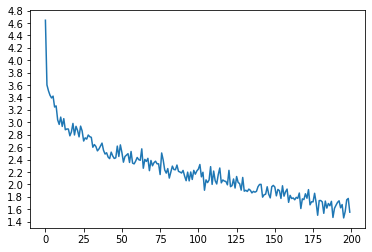

In [34]:
# We set the number of hidden layers to 256
hidden_size = 256

# We initialize our encoder RNN
## input_size of our encoder RNN is the length of our word index of the input language
## hidden_size of our encoder RNN is 256, which is a hyperparameter we set.
## we connect our encoder RNN to device (if GPU available GPU, if not, CPU.)
encoder1 = EncoderRNN(input_language.word_index, hidden_size).to(device)

# We initialize our decoder RNN
## input_size of our decoder RNN is 256, which is same as the output size of encoder RNN
## onput_size of our decoder RNN is the length of our word index of the output language
## we connect our encoder RNN to device (if GPU available GPU, if not, CPU.)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_language.word_index, dropout_p=0.1).to(device)

# Now encoder and decoder RNNs are ready.
## We execute the function "trainIters()" to perform the training process.
## we set encoder and decoder parametes. 
## We set training iterations to 20000
## We print process for every 5000 iterations. 
## We show training loss for every 100 iterations. 
## The learning rate is 0.01
trainIters(encoder1, attn_decoder1, 20000, print_every=5000, plot_every=100, learning_rate=0.01)

### Perform model evaluation

In [35]:
#  Execute the function "evaluateRandomly()" to print random results and to compare them with the correct translations
evaluateRandomly(encoder1, attn_decoder1)

Input sentence:  nous sommes suffisamment proches .
Correct translation:  we re close enough .
Predicted translation:  we re all . . <EOS>

Input sentence:  j etudie le francais .
Correct translation:  i m studying french .
Predicted translation:  i m going to the . <EOS>

Input sentence:  je recherche un assistant .
Correct translation:  i am looking for an assistant .
Predicted translation:  i m going to a a . <EOS>

Input sentence:  vous etes ruses .
Correct translation:  you re crafty .
Predicted translation:  you re the . <EOS>

Input sentence:  ils sont bons tous les deux .
Correct translation:  they are both good .
Predicted translation:  they are both good . <EOS>

Input sentence:  tu es fort attirant .
Correct translation:  you re very attractive .
Predicted translation:  you re very timid . <EOS>

Input sentence:  je crains que nous ayons un probleme .
Correct translation:  i m afraid we have a problem .
Predicted translation:  i m afraid we have a a . <EOS>

Input sentence: 

### Visualize attention
A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run plt.matshow(attentions) to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

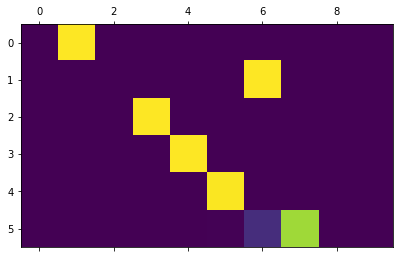

In [36]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())

# plt.title('Confusion matrix')
# plt.colorbar()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
plt.show()


For a better viewing experience we will do the extra work of adding axes and labels:

In [37]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


input = elle a cinq ans de moins que moi .
output = she is two years younger than me . <EOS>


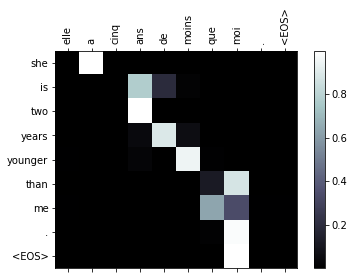

input = elle est trop petit .
output = she is too young . <EOS>


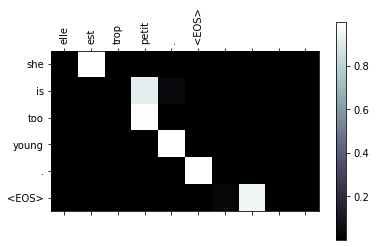

input = je ne crains pas de mourir .
output = i m not afraid of . . <EOS>


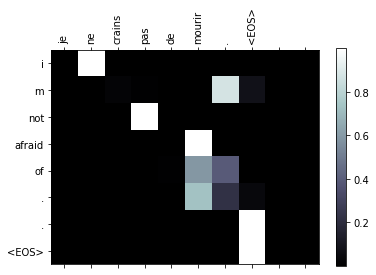

input = c est un jeune directeur plein de talent .
output = he is a very of . . <EOS>


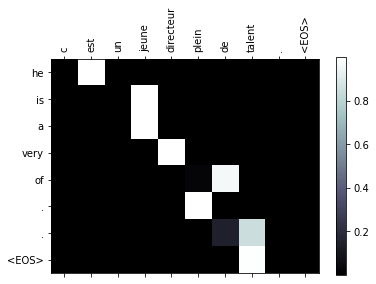

In [38]:
evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

# **References**

- [1] NLP and Computer Vision_DLMAINLPCV01 Course Book
- [2] https://opennmt.net/
- [3] https://github.com/OpenNMT/OpenNMT-py#quickstart


https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

https://stackoverflow.com/questions/59085745/what-is-the-inputs-to-a-torch-nn-gru-function-in-pytorch

.view()
https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

https://pytorch.org/docs/stable/tensor_view.html





Copyright © 2022 IU International University of Applied Sciences

# Notes for me
It is necessary to have both the model, and the data on the same device, either CPU or GPU, for the model to process data. Data on CPU and model on GPU, or vice-versa, will result in a Runtime error.

You can set a variable device to cuda if it's available, else it will be set to cpu, and then transfer data and model to device :

In [ ]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
data = data.to(device)

In [ ]:
# My code
hidden_size = 256
encoder1 = EncoderRNN(input_lang.word_index, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.word_index, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 20000, print_every=5000, plot_every=100, learning_rate=0.01)
